# Playing with probabilities computed by XGBoost


In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='playbox'
# Do a bit of checks before actually running code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))


### Shortcut : we load all domains from global repository

* BASIC
* NLTK_STOP_WORDS
* ALL_STOP_WORDS
* UNKNOWN
* CLEAN_ALL_STOP_WORDS
* LEMMATIZED
* ENTIIES
* NEWSGROUP
* SPACY SIMILARIIES

In [2]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

def glue_all_domains(unused,dataset_name):
    # Bootstrap with our last full save
    #copy_from_pandas_store_if_missing(dataset_name+'_clean_all_stop_words_features')
    print_warning('Load basic+nltk_stop_words+all_stop_words+clean_all_stop_words_features')
    dataframe = load_global_dataframe(dataset_name+'_clean_all_stop_words_features')
    
    #copy_from_pandas_store_if_missing(dataset_name+'_final_lemmatized_entities_features')
    lemmatized_entities = load_global_dataframe(dataset_name+'_final_lemmatized_entities_features')
    print_warning('Glue lemmes & entities')
    # The set_index option was specially tricky. Made me mad for a while
    dataframe = pandas.concat([dataframe,lemmatized_entities.set_index(dataframe.index)],axis=1)
    del lemmatized_entities

    #copy_from_pandas_store_if_missing(dataset_name+'_newsgroup_proba')
    print_warning('Glue newsgroups')
    newsgroup_proba = load_global_dataframe(dataset_name+'_newsgroup_proba')
    dataframe = pandas.concat([dataframe,newsgroup_proba.set_index(dataframe.index)],axis=1)
    del newsgroup_proba

    #copy_from_pandas_store_if_missing(dataset_name+'_spacy_similarity')
    print_warning('Glue spacy similarities')
    spacy_similarity = load_global_dataframe(dataset_name+'_spacy_similarity')
    # Glue similarities to dataframe
    # We have only a serie so it is much easier than with a full dataframe
    dataframe['spacy_similarity'] = spacy_similarity
    del spacy_similarity

    return dataframe


In [3]:
train_dataframe = load_or_build_dataframe('Glue all features to training','train_all_features',glue_all_domains,None,param1='train')
challenge_dataframe = load_or_build_dataframe('Glue all features to challenge','challenge_all_features',glue_all_domains,None,param1='challenge')


### Define all domains

In [4]:
# all_numeric_columns filter 
# * anything not int or fload 
# * id1,id2,test_id,is_duplicate and weight

# To build a model with only features not aware of any stop words
DOMAIN_BASIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' not in c and 'all' not in c and 'unknown' not in c and 'clean' not in c and 'entities' not in c and 'proba' not in c and 'similarity' not in c and 'lemmatized' not in c] 

# To build a model with only features aware of nltk stop words
DOMAIN_NLTK_STOP_WORDS_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'nltk' in c] 

DOMAIN_ALL_STOP_WORDS_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'all' in c and 'clean' not in c] 

# The 2 nb 'not in english dictionary' features 
DOMAIN_DICT_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'unknown' in c] 

# To build a model with only features aware of all stop words AFTER cleaning
DOMAIN_LEMMATIZED_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'lemmatized' in c] 

# To build a model with only features aware of all stop words AFTER cleaning
DOMAIN_CLEAN_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'clean' in c] 

# To build a model with only features aware of all stop words AFTER cleaning
DOMAIN_ENTITIES_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'entities' in c] 

# To build a model with only features aware of all stop words AFTER cleaning
DOMAIN_NEWSGROUP_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'proba' in c] 

# To build a model with only spacy similaraties
DOMAIN_SPACY_SIMILARITY_FEATURE = [c for c in all_numeric_columns(train_dataframe) if 'similarity' in c] 

# everything
ALL_FEATURES = all_numeric_columns(train_dataframe)

Check a little bit what we have loaded

In [5]:


nb_cols = len(train_dataframe.columns)
print_info('train_dataframe has %d columns' % nb_cols)
print_info('train_dataframe has %d DOMAIN_BASIC_FEATURES' % len(DOMAIN_BASIC_FEATURES))
print_info('train_dataframe has %d DOMAIN_NLTK_STOP_WORDS_FEATURES' % len(DOMAIN_NLTK_STOP_WORDS_FEATURES))
print_info('train_dataframe has %d DOMAIN_ALL_STOP_WORDS_FEATURES' % len(DOMAIN_ALL_STOP_WORDS_FEATURES))
print_info('train_dataframe has %d DOMAIN_DICT_FEATURES' % len(DOMAIN_DICT_FEATURES))
print_info('train_dataframe has %d DOMAIN_LEMMATIZED_FEATURES' % len(DOMAIN_LEMMATIZED_FEATURES))
print_info('train_dataframe has %d DOMAIN_CLEAN_FEATURES' % len(DOMAIN_CLEAN_FEATURES))
print_info('train_dataframe has %d DOMAIN_ENTITIES_FEATURES' % len(DOMAIN_ENTITIES_FEATURES))
print_info('train_dataframe has %d DOMAIN_NEWSGROUP_FEATURES' % len(DOMAIN_NEWSGROUP_FEATURES))
print_info('train_dataframe has %d DOMAIN_SPACY_SIMILARITY_FEATURE' % len(DOMAIN_SPACY_SIMILARITY_FEATURE))
print_info('train_dataframe has %d ALL_FEATURES' % len(ALL_FEATURES))

assert len(DOMAIN_BASIC_FEATURES) == 8,DOMAIN_BASIC_FEATURES
assert len(DOMAIN_NLTK_STOP_WORDS_FEATURES) == 8,DOMAIN_NLTK_STOP_WORDS_FEATURES
assert len(DOMAIN_ALL_STOP_WORDS_FEATURES) == 8,DOMAIN_ALL_STOP_WORDS_FEATURES
assert len(DOMAIN_DICT_FEATURES) == 2,DOMAIN_DICT_FEATURES
assert len(DOMAIN_LEMMATIZED_FEATURES) == 8,DOMAIN_LEMMATIZED_FEATURES 
assert len(DOMAIN_CLEAN_FEATURES) == 8,DOMAIN_CLEAN_FEATURES
assert len(DOMAIN_ENTITIES_FEATURES) == 48,DOMAIN_ENTITIES_FEATURES
assert len(DOMAIN_NEWSGROUP_FEATURES) == 14,DOMAIN_NEWSGROUP_FEATURES
assert len(DOMAIN_SPACY_SIMILARITY_FEATURE) == 1,DOMAIN_SPACY_SIMILARITY_FEATURE
assert len(ALL_FEATURES)==105,ALL_FEATURES

assert 'weight' in train_dataframe and 'weight' not in ALL_FEATURES
assert len(train_dataframe['weight'].unique())==2
print_info('weight column is OK')
assert 'is_duplicate' in train_dataframe and 'is_duplicate' not in ALL_FEATURES
assert len(train_dataframe['is_duplicate'].unique())==2

# all domains are disjoint
assert len(set(DOMAIN_BASIC_FEATURES) 
        & set(DOMAIN_NLTK_STOP_WORDS_FEATURES) 
        & set(DOMAIN_ALL_STOP_WORDS_FEATURES) 
        & set(DOMAIN_DICT_FEATURES) 
        & set(DOMAIN_LEMMATIZED_FEATURES) 
        & set(DOMAIN_CLEAN_FEATURES) 
        & set(DOMAIN_ENTITIES_FEATURES) 
        & set(DOMAIN_NEWSGROUP_FEATURES) 
        & set(DOMAIN_SPACY_SIMILARITY_FEATURE) 
        ) == 0
print_info('All domains are disjoint')
assert len(DOMAIN_BASIC_FEATURES) + len(DOMAIN_NLTK_STOP_WORDS_FEATURES) + len(DOMAIN_ALL_STOP_WORDS_FEATURES) + len(DOMAIN_DICT_FEATURES) + len(DOMAIN_LEMMATIZED_FEATURES) + len(DOMAIN_CLEAN_FEATURES) + len(DOMAIN_ENTITIES_FEATURES) + len(DOMAIN_NEWSGROUP_FEATURES) + len(DOMAIN_SPACY_SIMILARITY_FEATURE) == len(ALL_FEATURES)
print_info('All columns are used in a domain')

assert len(train_dataframe)==404290,len(train_dataframe)
print()
print_info('train_dataframe looks like OK')

for c in ALL_FEATURES:
    assert c in challenge_dataframe.columns

assert 'is_duplicate' not in challenge_dataframe and 'weight' not in challenge_dataframe
assert len(train_dataframe['is_duplicate'].unique())==2

assert len(challenge_dataframe)==2345796,len(challenge_dataframe)
print_info('challenge_dataframe looks like ok')


OK we have loaded what expected

We can go further

Define code for a default xgboost model


In [6]:
# Simple XGBoost code
# 

import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }



def print_res_xgboost(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))

# 80% training 20% validation
def build_XGBoost_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

# Pushing the limits :100 % training no validation !!
# Just in case it allows to gain small digts in kaggle score...
def build_XGBoost_model_100_0(training,target,column_names,show=True):
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight,nthread = -1)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,sample_weight = final_weight,show=show)
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }

INFO_XGBOOST_MODEL= {
    'logloss_proba': '%.4f',
    'score': '%.4f',
    'accuracy': '%.4f',
    'time': '%.2f'
}

print_res_xgboost({'alain':1})

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

[0]	train-logloss:0.68197
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59052
[20]	train-logloss:0.52549
[30]	train-logloss:0.47724
[40]	train-logloss:0.44029
[50]	train-logloss:0.41141
[60]	train-logloss:0.38875
[70]	train-logloss:0.37040
[80]	train-logloss:0.35535
[90]	train-logloss:0.34310
[100]	train-logloss:0.33268
[110]	train-logloss:0.32418
[120]	train-logloss:0.31696
[130]	train-logloss:0.31114
[140]	train-logloss:0.30598
[150]	train-logloss:0.30140
[160]	train-logloss:0.29727
[170]	train-logloss:0.29339
[180]	train-logloss:0.28983
[190]	train-logloss:0.28629
[200]	train-logloss:0.28344
[210]	train-logloss:0.28053
[220]	train-logloss:0.27800
[230]	train-logloss:0.27514
[240]	train-logloss:0.27252
[250]	train-logloss:0.27009
[260]	train-logloss:0.26739
[270]	train-logloss:0.26424
[280]	train-logloss:0.26162
[290]	train-logloss:0.25903
[300]	train-logloss:0.25688
[310]	train-logloss:0.25462
[320]	train-logloss:0.25215
[330]	train-logloss:0.2497

              precision    recall  f1-score   support

           0       0.90      0.99      0.95 833.5098453967706
           1       0.94      0.48      0.63 171.66892895091271

    accuracy                           0.91 1005.1787743476833
   macro avg       0.92      0.74      0.79 1005.1787743476833
weighted avg       0.91      0.91      0.89 1005.1787743476833



{'accuracy': 0.9058721529352717, 'score': 0.8928541591821343, 'logloss_proba': 0.23583724567458317, 'model': <xgboost.core.Booster object at 0x7f1eaf932df0>, 'time': 1.7962052822113037}


[0]	train-logloss:0.68206	valid-logloss:0.68148
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59137	valid-logloss:0.58652
[20]	train-logloss:0.52546	valid-logloss:0.52009
[30]	train-logloss:0.47733	valid-logloss:0.47161
[40]	train-logloss:0.44052	valid-logloss:0.43465
[50]	train-logloss:0.41200	valid-logloss:0.40639
[60]	train-logloss:0.38931	valid-logloss:0.38460
[70]	train-logloss:0.37100	valid-logloss:0.36765
[80]	train-logloss:0.35616	valid-logloss:0.35439
[90]	train-logloss:0.34454	valid-logloss:0.34463
[100]	train-logloss:0.33469	valid-logloss:0.33717
[110]	train-logloss:0.32643	valid-logloss:0.33094
[120]	train-logloss:0.31933	valid-logloss:0.32609
[130]	train-logloss:0.31357	valid-logloss:0.32240
[140]	train-logloss:0.30843	valid-logloss:0.31881
[150]	train-logloss:0.30402	valid-logloss:0.31669
[160]	train-logloss:0.29995	valid-logloss:0.31457
[170]	trai

              precision    recall  f1-score   support

           0       0.85      0.95      0.90 168.7955573880411
           1       0.38      0.17      0.23 33.5771183347514

    accuracy                           0.82 202.37267572279248
   macro avg       0.62      0.56      0.57 202.37267572279248
weighted avg       0.77      0.82      0.79 202.37267572279248



{'accuracy': 0.8168647959159321, 'score': 0.7862304951940857, 'logloss_proba': 0.30658844459889373, 'model': <xgboost.core.Booster object at 0x7f1eaf932610>, 'time': 1.8827314376831055}


Another bunch of code to wrap
* building a set of xgboost models from the 'exploration' a set of features (possibly no exploration)
* find the best model according to a metric (default is logloss)
* save the metrics and all models in a 'database'
* export all metrics of all models in excel
* predict all probabilities from challenge dataset
* prepare submission to kaggle 

** Note the 'database of models' is cached : if it can be retrieved, it is not rebuilt** 

In [7]:
def find_best_result(results,metric):
    if 'logloss' in metric:
        return results.nsmallest(1,metric)
    else:
        return results.nlargest(1,metric)
        
def apply_xgboost(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df[columns]))
    return res

def submit_best_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

def n_columns(columns,n):
    return columns[0:n]

def xgboost_all_fields_80_20(dataframe,columns_to_explore,explore=True,show=False):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBoost_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = show)
        cur_logloss = res['logloss_proba']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %s" % (i,cur_logloss,columns))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f" % (i,cur_logloss))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_fields(message,tag,columns,train_df,challenge_df,explore=True,show=False):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBoost models',tag + '_results',lambda df:xgboost_all_fields_80_20(df,columns,explore=explore,show=show),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    submit_best_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results

Let's build a model 
* with all features 
* no exploration : current exploration is just adding one field at a time and is quite useless now
* show progression of the training

In [8]:
xgboost_everything_results = study_fields(
    'Everything we have',
    'everything_xgboost',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = True)

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833984,0.786622,0.326652,91.557519
std,NaN,NaN,NaN,NaN
min,0.833984,0.786622,0.326652,91.557519
25%,0.833984,0.786622,0.326652,91.557519
50%,0.833984,0.786622,0.326652,91.557519
75%,0.833984,0.786622,0.326652,91.557519
max,0.833984,0.786622,0.326652,91.557519


This is currently our best model according to kaggle:
* public score: 0.33623
* private score: 0.33861

These scores are in the 20 % best scores from all teams

**However**, this is the kaggle score. What about the usual metrics for classification ? 

For example, confusion matrix ...

1. XGBoost outputs only probabilities
2. A threshold must be applied to decide if prediction is 1 or 0. Default is obviously 0.5

In [9]:
# Get back our model
model = xgboost_everything_results['model'][0]
# do the usual split (80,20)
input_train,input_test,target_train,target_test = train_test_split(train_dataframe,train_dataframe['is_duplicate'],random_state=42,test_size=0.2)
test_probabilities = model.predict(xgboost.DMatrix(input_test[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)
train_probabilities = model.predict(xgboost.DMatrix(input_train[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)
challenge_probabilities = model.predict(xgboost.DMatrix(challenge_dataframe[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)

# Apply the usual threshold
test_predictions = numpy.where(test_probabilities>0.5,1,0)
train_predictions = numpy.where(train_probabilities>0.5,1,0)
challenge_predictions = numpy.where(challenge_probabilities>0.5,1,0)

What do we have in predictions ?

In [10]:
print_info('On test %% of true duplicates is %.3f' % target_test.mean())
print_warning('On test %% of predicted duplicates is %.3f !!' % test_predictions.mean())

print_info('On train %% of true duplicates is %.3f' % target_train.mean())
print_warning('On train %% of predicted duplicates is %.3f !!' % train_predictions.mean())

print_warning('On challenge %% of predicted duplicates is %.3f !!' % challenge_predictions.mean())

Looks like we have a calibration issue

Let's check it with a reliability graph (or calibration curve)

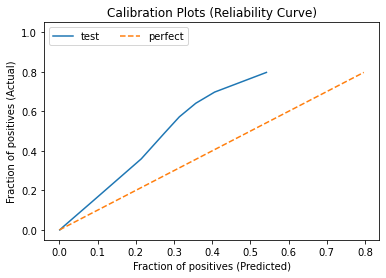

In [12]:
from sklearn.calibration import calibration_curve

plot_test_truth, plot_test_predictions = calibration_curve(target_test, test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test')
# Useless to draw train curve : almost identical to test and therefore, invisible
#plot_train_truth, plot_train_predictions = calibration_curve(target_train, train_probabilities,strategy='quantile', n_bins=10)
#plot.plot(plot_train_predictions, plot_train_truth,label='train')

xmin = min(plot_test_predictions.min(), plot_test_truth.min())
xmax = max(plot_test_predictions.max(), plot_test_truth.max())
plot.plot([xmin,xmax],[xmin,xmax], '--',label='perfect')
#plot.plot([0, 1], [0, 1], '--', label='perfect')
plot.xlabel('Fraction of positives (Predicted)')
plot.ylabel('Fraction of positives (Actual)')
plot.ylim([-0.05, 1.05])
plot.legend(loc='upper left', ncol=2)
plot.title('Calibration Plots (Reliability Curve)')
plot.show()


That's it : blue line is largely above the truth, meaning probabilities are very underestimated: model is under-casting

All metrics from confusion matrix are false...

We have to recalibrate!! 
* Platt scaling : builds a logistic regression model where only input is uncalibrated probabilities and output true target
* Isotonic regression : make a piecewise calibration


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

class MyPlattScaling(BaseEstimator):
    def __init__(self, log_odds: bool=True):
        self.log_odds = log_odds
    
    def fit(self, y_prob: numpy.ndarray, y_true: numpy.ndarray):
        self.fit_predict(y_prob, y_true)
        return self

    @staticmethod
    def _convert_to_log_odds(y_prob: numpy.ndarray):
        eps = 1e-12
        y_prob = numpy.clip(y_prob, eps, 1 - eps)
        y_prob = numpy.log(y_prob / (1 - y_prob))
        return y_prob

    def predict(self, y_prob: numpy.ndarray):
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        output = self._transform(y_prob)
        return output

    def _transform(self, y_prob: numpy.ndarray):
        output = y_prob * self.coef_[0] + self.intercept_
        output = 1 / (1 + numpy.exp(-output))
        return output

    def fit_predict(self, y_prob: numpy.ndarray, y_true: numpy.ndarray) -> numpy.ndarray:
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        # the class expects 2d ndarray as input features
        logistic = LogisticRegression(C=1e10, solver='lbfgs')
        logistic.fit(y_prob.reshape(-1, 1), y_true)
        self.coef_ = logistic.coef_[0]
        self.intercept_ = logistic.intercept_

        y_calibrated_prob = self._transform(y_prob)
        return y_calibrated_prob

Graph this calibration

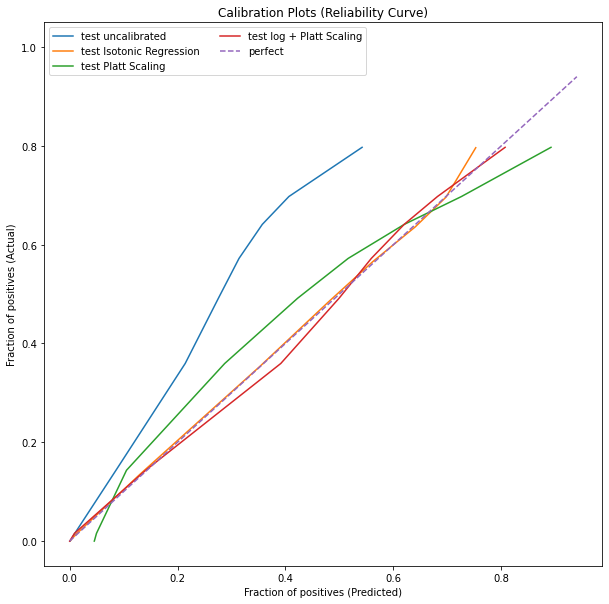

In [18]:
from sklearn.calibration import IsotonicRegression

isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=train_probabilities.min(),
                              y_max=train_probabilities.max())
# still valid: learn on train, predict on test
isotonic.fit(train_probabilities,target_train)
isotonic_test_probabilities = isotonic.predict(test_probabilities)

platt = MyPlattScaling(log_odds=False)
# still valid: learn on train, predict on test
platt.fit(train_probabilities,target_train)
platt_test_probabilities = platt.predict(test_probabilities)
platt_train_probabilities = platt.predict(train_probabilities)

# fig,ax = plot.subplots()
plot.figure(figsize=(10, 10))
plot_test_truth, plot_test_predictions = calibration_curve(target_test, test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test uncalibrated')

plot_test_truth, plot_test_predictions = calibration_curve(target_test, isotonic_test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test Isotonic Regression')

plot_test_truth, plot_test_predictions = calibration_curve(target_test, platt_test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test Platt Scaling')

platt_log = MyPlattScaling(log_odds=True)
# still valid: learn on train, predict on test
platt_log.fit(train_probabilities,target_train)
platt_log_test_probabilities = platt_log.predict(test_probabilities)
plot_test_truth, plot_log_test_predictions = calibration_curve(target_test, platt_log_test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_log_test_predictions, plot_test_truth,label='test log + Platt Scaling')

xmin = min(platt_log_test_probabilities.min(), plot_test_truth.min())
xmax = max(platt_log_test_probabilities.max(), plot_test_truth.max())
plot.plot([xmin,xmax],[xmin,xmax], '--',label='perfect')
plot.xlabel('Fraction of positives (Predicted)')
plot.ylabel('Fraction of positives (Actual)')
plot.ylim([-0.05, 1.05])
plot.legend(loc='upper left', ncol=2)
plot.title('Calibration Plots (Reliability Curve)')
plot.show()

new_test_log_predictions = numpy.where(platt_log_test_probabilities>0.5,1,0)
print_warning('Now, we have %.3f %% of 1 using log+Platt"s scaling recalibrated probabilities' % new_test_log_predictions.mean())

new_test_isotonic_predictions = numpy.where(isotonic_test_probabilities>0.5,1,0)
print_warning('Now, we have %.3f %% of 1 using Isotonic"s recalibrated probabilities' % new_test_isotonic_predictions.mean())

new_test_predictions = numpy.where(platt_test_probabilities>0.5,1,0)
print_info('Now, we have %.3f %% of 1 using Platt"s scaling recalibrated probabilities' % new_test_predictions.mean())



How is impacted confusion matrix

In [ ]:
#target_train.mean()
platt_test_probabilities.mean()

In [19]:
# test_predictions : predictions using uncalibrated probabilities
# test_probabilities : uncalibrated probabilities 
# new_test_predictions : predictions using calibrated probabilities with Plott scaling
# platt_test_probabilities : calibrated probabilities
# target_test : the truth
print_info('Test has %d rows' %len(target_test))

print_warning('Uncalibrated')
print_warning("logloss % .3f" % metrics.log_loss(target_test,test_probabilities,sample_weight = input_test['weight']))
print(metrics.classification_report(target_test,test_predictions,sample_weight = input_test['weight']))

print_info('Calibrated')
print_info("logloss % .3f" % metrics.log_loss(target_test,platt_test_probabilities,sample_weight = input_test['weight']))
print(metrics.classification_report(target_test,new_test_predictions,sample_weight = input_test['weight']))

#compare = pandas.DataFrame()
#compare['is_duplicate'] = target_test
#compare['uncalibrated'] = test_predictions
#compare['calibrated'] = new_test_predictions

              precision    recall  f1-score   support

           0       0.84      0.98      0.91 66475.35427891841
           1       0.63      0.14      0.22 14213.525233116525

    accuracy                           0.83 80688.87951203494
   macro avg       0.74      0.56      0.57 80688.87951203494
weighted avg       0.81      0.83      0.79 80688.87951203494



              precision    recall  f1-score   support

           0       0.92      0.82      0.87 66475.35427891841
           1       0.44      0.68      0.54 14213.525233116525

    accuracy                           0.79 80688.87951203494
   macro avg       0.68      0.75      0.70 80688.87951203494
weighted avg       0.84      0.79      0.81 80688.87951203494



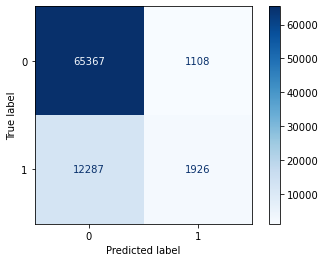

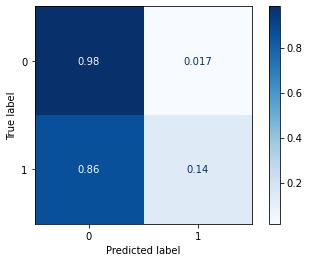

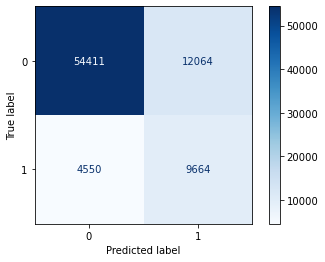

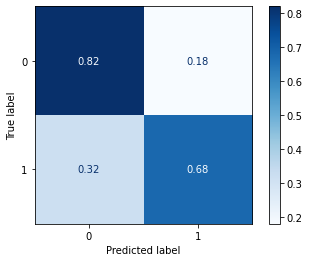

In [20]:
# test_predictions : predictions using uncalibrated probabilities
# test_probabilities : uncalibrated probabilities 
# new_test_predictions : predictions using calibrated probabilities with Plott scaling
# platt_test_probabilities : calibrated probabilities
# target_test : the truth

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print_warning('Uncalibrated')
uncalibrated_confusion_matrix = confusion_matrix(target_test,test_predictions,sample_weight=input_test[WEIGHT])
ConfusionMatrixDisplay(uncalibrated_confusion_matrix).plot(cmap=plot.cm.Blues,values_format=".0f")
uncalibrated_confusion_matrix = confusion_matrix(target_test,test_predictions,sample_weight=input_test[WEIGHT],normalize="true")
ConfusionMatrixDisplay(uncalibrated_confusion_matrix).plot(cmap=plot.cm.Blues)

print_info('Calibrated with Plott Scaling')
calibrated_confusion_matrix = confusion_matrix(target_test,new_test_predictions,sample_weight=input_test[WEIGHT])
ConfusionMatrixDisplay(calibrated_confusion_matrix).plot(cmap=plot.cm.Blues,values_format=".0f")
calibrated_confusion_matrix = confusion_matrix(target_test,new_test_predictions,sample_weight=input_test[WEIGHT],normalize="true")
ConfusionMatrixDisplay(calibrated_confusion_matrix).plot(cmap=plot.cm.Blues)

Everything using sklearn wrappers on top of xgboost


In [21]:

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3,
    'n_estimators' : 400, # xgboost direct ->  num_boost_round
    'n_jobs': os.cpu_count()
    }

def print_res_XGBClassifier(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))


def build_XGBClassifier_model_80_20(training,target,column_names,show=True):
    start = time.time()
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[column_names]
    final_input_test = input_test[column_names]
    model = xgboost.XGBClassifier(**params)
    model.fit(
        final_input_train,
        target_train,
        eval_set=[(final_input_train, target_train), (final_input_test, target_test)],
        sample_weight = input_train[WEIGHT],
        early_stopping_rounds = 50,
        eval_metric = 'logloss',
        verbose=show)
    infos = compute_metrics_model_XGBClassifier(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_XGBClassifier(infos)
    return  infos

def compute_metrics_model_XGBClassifier(model,input_df,target_df,sample_weight = None,show = True):
    prediction_proba_df = model.predict_proba(input_df)[:, 1]
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)  
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }



if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    res = build_XGBClassifier_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train),show=False)
    print(res)

{'accuracy': 0.8308859721825991, 'score': 0.8084482327861383, 'logloss_proba': 0.3068263743138645, 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.02,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0199999996,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=7,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None), 'time': 1.0045511722564697}


In [22]:
def XGBClassifier_all_fields_80_20(dataframe,columns_to_explore,explore=True,show=False):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBClassifier_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = show)
        cur_logloss = res['logloss_proba']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %s" % (i,cur_logloss,columns))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f" % (i,cur_logloss))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_XGBClassifier(message,tag,columns,train_df,challenge_df,explore=True,show=False):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBClassifiers models',tag + '_results',lambda df:XGBClassifier_all_fields_80_20(df,columns,explore=explore,show=show),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    submit_best_XGBClassifier_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results

def apply_XGBClassifier(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict_proba(input_df[columns])[:, 1]
    return res

def submit_best_XGBClassifier_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_XGBClassifier(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

In [23]:
XGBClassifier_everything_results = study_XGBClassifier(
    'Everything we have with XGBClassifier',
    'everything_XGBClassifier',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

,accuracy,score,logloss_proba,time
count,1.000000,1.000000,1.000000,1.000000
mean,0.833984,0.786622,0.326652,108.979637
std,NaN,NaN,NaN,NaN
min,0.833984,0.786622,0.326652,108.979637
25%,0.833984,0.786622,0.326652,108.979637
50%,0.833984,0.786622,0.326652,108.979637
75%,0.833984,0.786622,0.326652,108.979637
max,0.833984,0.786622,0.326652,108.979637


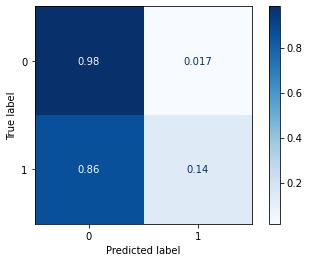

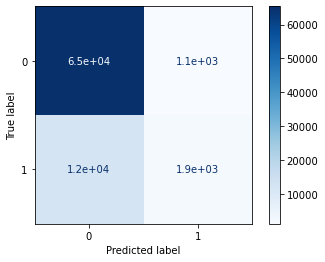

In [24]:
from sklearn.metrics import plot_confusion_matrix

model_XGBClassifier = XGBClassifier_everything_results['model'][0]
plot_confusion_matrix(model_XGBClassifier, input_test[ALL_FEATURES], target_test,sample_weight=input_test[WEIGHT],normalize='true',cmap=plot.cm.Blues)
plot_confusion_matrix(model_XGBClassifier, input_test[ALL_FEATURES], target_test,sample_weight=input_test[WEIGHT],cmap=plot.cm.Blues)



What is happening with challenge data

Compute all decisions in challenge with our recalibrated probabilities. 

Double shot
* XGBoost model generates probabilities
* Logistic regression recalibrate these probabilities


In [25]:
def calibrated_probabilities(model,calibrator,input_df,columns,message):
    print_section('Scoring XGBoost model with calibration: %s' % message)
    prediction_proba = apply_xgboost(model,columns,input_df)
    prediction_proba['is_duplicate'] = calibrator.predict(prediction_proba['is_duplicate'])
    print_done('calibration done')
    return prediction_proba

In [26]:
challenge_platt_probabilities = calibrated_probabilities(model,platt,challenge_dataframe,ALL_FEATURES,'Platt scaling')
challenge_log_platt_probabilities = calibrated_probabilities(model,platt_log,challenge_dataframe,ALL_FEATURES,'Log + Platt scaling')
challenge_isotonic_probabilities = calibrated_probabilities(model,isotonic,challenge_dataframe,ALL_FEATURES,'Isotonic regression')


Simple Plott scaling is definitely the winner

Not perfect but we would be able to generate decisions in challenge matching the guessed ratio of 1 !

In [27]:
print_warning('Challenge decisions with uncalibrated probabilities %% of 1 : %.3f' % numpy.where(challenge_probabilities>0.5,1,0).mean())

print_info('Challenge decisions with Platt Scaling %% of 1 : %.3f' %numpy.where(challenge_platt_probabilities['is_duplicate']>0.5,1,0).mean())

print_warning('Challenge decisions with log+Platt scaling %% of 1 : %.3f' % numpy.where(challenge_log_platt_probabilities['is_duplicate']>0.5,1,0).mean())

print_warning('Challenge decisions with Isotonic Regression %% of 1 : %.3f' % numpy.where(challenge_isotonic_probabilities['is_duplicate']>0.5,1,0).mean())


In [138]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

def hyperopt_optimize(training,target,column_names,trials,show=False):

    parameters_space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', numpy.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'nthread': 8,
        #'booster': 'gbtree',
        #'tree_method': 'exact',
        'seed': 42,
        "seed_per_iteration": True,
        "tree_method": "hist"
    }

    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    def eval_model(params):
        num_round = int(params['n_estimators'])
        del params['n_estimators']
        model = xgboost.train(params,train_dm,num_round,watchlist,early_stopping_rounds=50,verbose_eval=show)
        prediction_proba_df = model.predict(validation_dm,ntree_limit=model.best_iteration + 1)
        logloss = metrics.log_loss(target_test,prediction_proba_df,sample_weight = input_test[WEIGHT])
        return {'loss': logloss, 'status': STATUS_OK, 'model' : model, 'logloss':logloss}

    # Use the hyperopt's fmin
    start = time.time()
    print_section('Finding hyperparameters')
    best = fmin(eval_model, parameters_space, algo=tpe.suggest, 
                trials=trials, 
                max_evals=200)
    print_done('Done',top=start)
    return best

In [140]:
trials = Trials()
best_xgboost_parameters = hyperopt_optimize(train_dataframe.sample(200000,random_state=42),train_dataframe['is_duplicate'].sample(200000,random_state=42),ALL_FEATURES,trials,show=False)

100%|██████████| 200/200 [2:14:03<00:00, 40.22s/trial, best loss: 0.2923310758690384]


In [141]:
best_params

{'colsample_bytree': 0.75,
 'eta': 0.05,
 'gamma': 0.7000000000000001,
 'max_depth': 9,
 'min_child_weight': 6.0,
 'n_estimators': 819.0,
 'subsample': 0.9500000000000001}

avg best error: 0.2923310758690384


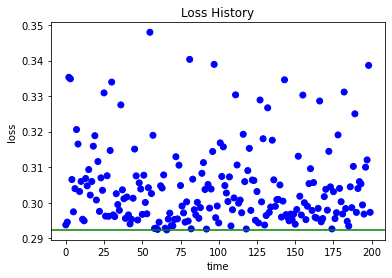

Showing Histogram of 200 jobs


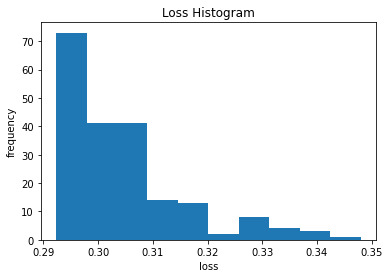

finite loss range 0.2923310758690384 0.34797517449488036 -0.7076689241309616


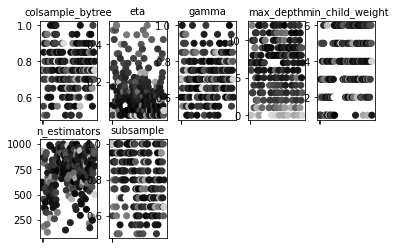

In [142]:
import hyperopt.plotting

hyperopt.plotting.main_plot_history(trials)
hyperopt.plotting.main_plot_histogram(trials)
hyperopt.plotting.main_plot_vars(trials)

In [146]:
optim_params = {'colsample_bytree': 0.9500000000000001,
 'eta': 0.17500000000000002,
 'gamma': 0.7000000000000001,
 'max_depth': 11,
 'min_child_weight': 5.0,
 'n_estimators': 358.0,
 'subsample': 0.8500000000000001}

optim_params = {'colsample_bytree': 0.55,
 'eta': 0.05,
 'gamma': 0.55,
 'max_depth': 5,
 'min_child_weight': 2.0,
 'n_estimators': 823.0,
 'subsample': 0.7000000000000001}

 
optim_params = {'colsample_bytree': 0.75,
 'eta': 0.05,
 'gamma': 0.7000000000000001,
 'max_depth': 9,
 'min_child_weight': 6.0,
 'n_estimators': 819.0,
 'subsample': 0.9500000000000001}

xgboost_everything_optim_results = study_fields(
    'Everything we have with optim',
    'everything_xgboost_with_optim',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

[06:49:06] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,accuracy,score,logloss_proba,time
count,1.000000,1.000000,0.0,1.000000
mean,0.862698,0.849554,NaN,712.776043
std,NaN,NaN,NaN,NaN
min,0.862698,0.849554,NaN,712.776043
25%,0.862698,0.849554,NaN,712.776043
50%,0.862698,0.849554,NaN,712.776043
75%,0.862698,0.849554,NaN,712.776043
max,0.862698,0.849554,NaN,712.776043


IndexError: index out of bounds

In [43]:
xgboost_everything_optim_results['model'][0].get_score(importance_type='gain')


{'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)': 2525.3547304785316,
 'nb_common_words/(nb_words_question1+nb_words_question2)': 213.21156317484585,
 'lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)': 1001.67133789375,
 'spacy_similarity': 322.96738812869756,
 'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)': 301.27660764338475,
 'clean_all_nb_words_question2': 363.36937190454546,
 'lemmatized_nb_common_words/lemmatized_nb_words_question1': 631.0159720188408,
 'nb_common_words/nb_words_question1': 347.2288441282609,
 'nb_words_question1-common_words': 430.4920596518519,
 'nb_unknown_question2': 404.67837823012036,
 'nb_common_words': 316.0324969898334,
 'nb_unknown_question1': 406.04573741964293,
 'nltk_nb_words_question2-nltk_common_words': 326.84458900740754,
 'all_nb_common_words': 398.7529801,
 'clean_all_nb_words_question1': 514.5142823636363,
 'proba_politics_question2': 106.6341928026667,
 'l

In [143]:
trials.best_trial['misc']['vals']

{'colsample_bytree': [0.75],
 'eta': [0.05],
 'gamma': [0.7000000000000001],
 'max_depth': [9],
 'min_child_weight': [6.0],
 'n_estimators': [819.0],
 'subsample': [0.9500000000000001]}

In [153]:
OPTIM_XGBOOST_PARAMS = {'colsample_bytree': 0.75,
 'eta': 0.05,
 'gamma': 0.7000000000000001,
 'max_depth': 9,
 'min_child_weight': 6.0,
 # 'n_estimators': 819.0, Looks like an issue
 'subsample': 0.9500000000000001}
OPTIM_N_ESTIMATORS = 819

def build_XGBoost_optim_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT],nthread = -1)

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    print_info('optimised parameters: ESTIMATORS %d %s' % (OPTIM_N_ESTIMATORS,optim_params))
    model = xgboost.train(
        OPTIM_XGBOOST_PARAMS,
        train_dm,
        OPTIM_N_ESTIMATORS,
        [(train_dm, 'train'), (validation_dm, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def get_xgboost_params(model):
    return json.loads(model.save_config())

def submit_model(model,input_df,columns,file_name,kaggle_message):
    start = time.time()
    print_section("Scoring XGBoost model : %s" % kaggle_message)
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction


In [152]:
res = build_XGBoost_optim_model_80_20(train_dataframe,train_dataframe['is_duplicate'],ALL_FEATURES,show=False)

In [164]:
predictions_bizz = submit_model(xgboost_everything_optim_results['model'][0],challenge_dataframe,ALL_FEATURES,'xgboost_everything_optim_','xgboost_everything_optim_')
predictions_bizz

,test_id,is_duplicate
0,0,0.006294
1,1,0.226818
2,2,0.316173
3,3,0.000886
4,4,0.258781
...,...,...
2345791,2345791,0.000796
2345792,2345792,0.004725
2345793,2345793,0.001027
2345794,2345794,0.181528


In [155]:
hyper_pred_proba = submit_model(res['model'],challenge_dataframe,ALL_FEATURES,'hyper_opt_on_all_features','all features + hyperopt 200x200000')

In [162]:
hyper_pred_proba

,test_id,is_duplicate
0,0,-0.009312
1,1,0.340538
2,2,0.497711
3,3,0.004402
4,4,0.297334
...,...,...
2345791,2345791,-0.001743
2345792,2345792,-0.000409
2345793,2345793,-0.006672
2345794,2345794,0.250876


In [161]:
hyper_pred_proba[hyper_pred_proba['is_duplicate']<0].count()

test_id         554870
is_duplicate    554870
dtype: int64

In [107]:


config = get_params(res['model'])
config

{'learner': {'generic_param': {'enable_experimental_json_serialization': '0',
   'gpu_id': '-1',
   'gpu_page_size': '0',
   'n_gpus': '0',
   'n_jobs': '0',
   'nthread': '0',
   'random_state': '0',
   'seed': '0',
   'seed_per_iteration': '0',
   'validate_parameters': '1'},
  'gradient_booster': {'gbtree_train_param': {'num_parallel_tree': '1',
    'predictor': 'auto',
    'process_type': 'default',
    'tree_method': 'exact',
    'updater': 'grow_colmaker,prune',
    'updater_seq': 'grow_colmaker,prune'},
   'name': 'gbtree',
   'specified_updater': False,
   'updater': {'grow_colmaker': {'colmaker_train_param': {'opt_dense_col': '1'},
     'train_param': {'alpha': '0',
      'cache_opt': '1',
      'colsample_bylevel': '1',
      'colsample_bynode': '1',
      'colsample_bytree': '0.949999988',
      'default_direction': 'learn',
      'enable_feature_grouping': '0',
      'eta': '0.174999997',
      'gamma': '0.699999988',
      'grow_policy': 'depthwise',
      'interaction_con

In [112]:
def submit_model(model,input_df,columns,file_name,kaggle_message):
    start = time.time()
    print_section("Scoring XGBoost model : %s" % kaggle_message)
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

In [114]:
submit_model(res['model'],challenge_dataframe,ALL_FEATURES,'todel','all with hyper 2')

,test_id,is_duplicate
0,0,-0.019247
1,1,0.407040
2,2,0.507533
3,3,0.013447
4,4,0.302501
...,...,...
2345791,2345791,-0.021321
2345792,2345792,0.001088
2345793,2345793,-0.008523
2345794,2345794,0.222875


In [160]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,3))

,date,publicScore,privateScore,description,fileName
0,2020-10-09 07:49:33,0.32483,0.32736,playbox all features + hyperopt 200x200000,hyper_opt_on_all_features.zip
1,2020-10-08 22:01:24,0.38188,0.38887,playbox all with hyper 2,todel.zip
2,2020-10-08 20:31:08,0.33623,0.33861,playbox Best everything_xgboost_with_optim,Best_everything_xgboost_with_optim.zip


,publicScore,date,privateScore,description,fileName
0,0.32483,2020-10-09 07:49:33,0.32736,playbox all features + hyperopt 200x200000,hyper_opt_on_all_features.zip
2,0.33623,2020-10-08 20:31:08,0.33861,playbox Best everything_xgboost_with_optim,Best_everything_xgboost_with_optim.zip
3,0.33623,2020-10-08 14:16:34,0.33861,playbox Best everything_XGBClassifier,Best_everything_XGBClassifier.zip


In [119]:
trials.best_trial

{'state': 2,
 'tid': 5,
 'spec': None,
 'result': {'loss': 0.28122724872973387,
  'status': 'ok',
  'model': <xgboost.core.Booster at 0x7f1ea005ea30>},
 'misc': {'tid': 5,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [5],
   'eta': [5],
   'gamma': [5],
   'max_depth': [5],
   'min_child_weight': [5],
   'n_estimators': [5],
   'subsample': [5]},
  'vals': {'colsample_bytree': [0.8500000000000001],
   'eta': [0.30000000000000004],
   'gamma': [0.75],
   'max_depth': [11],
   'min_child_weight': [5.0],
   'n_estimators': [417.0],
   'subsample': [0.8]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 10, 8, 21, 23, 55, 43000),
 'refresh_time': datetime.datetime(2020, 10, 8, 21, 23, 55, 200000)}

Text(0, 0.5, '$x$')

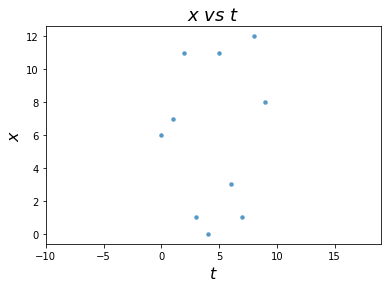

In [120]:
f, ax = plot.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['max_depth'] for t in trials.trials]
ax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

Text(0, 0.5, '$x$')

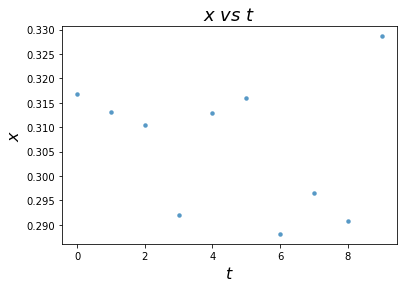

In [126]:
f, ax = plot.subplots(1)
xs = [t['tid'] for t in trials.trials]
ys = [t['result']['logloss'] for t in trials.trials]
#Faax.set_xlim(xs[0]-10, xs[-1]+10)
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax.set_title('$x$ $vs$ $t$ ', fontsize=18)
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('$x$', fontsize=16)

In [121]:
for t in trials:
    print()
    print(t)res


{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 0.29991183554418577, 'status': 'ok', 'model': <xgboost.core.Booster object at 0x7f1e5f68fa60>}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'colsample_bytree': [0], 'eta': [0], 'gamma': [0], 'max_depth': [0], 'min_child_weight': [0], 'n_estimators': [0], 'subsample': [0]}, 'vals': {'colsample_bytree': [0.55], 'eta': [0.47500000000000003], 'gamma': [0.6000000000000001], 'max_depth': [6], 'min_child_weight': [5.0], 'n_estimators': [619.0], 'subsample': [0.8]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 10, 8, 21, 23, 54, 247000), 'refresh_time': datetime.datetime(2020, 10, 8, 21, 23, 54, 346000)}

{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 0.2891599441567252, 'status': 'ok', 'model': <xgboost.core.Booster object at 0x7f1e5f545670>}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'col